## Import Libraries

In [1]:
! /opt/conda/envs/py39/bin/python -m pip install pandas_ta

In [2]:
import gym
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta
from stockstats import StockDataFrame as Sdf
from finrl.agents.stablebaselines3.models import A2C

from finrl.agents.stablebaselines3.models import DummyVecEnv
from sklearn.preprocessing import StandardScaler

## Importing local modules

In [3]:
import os
import sys
sys.path.append('../')
from src.rl_env.stock import SingleStockEnv
from src.models.models import RLModels
from src.data.make_dataset import download_stock_data

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download and save the data in a pandas DataFrame:
data_df = download_stock_data("TSLA ", start_date="2017-01-01", end_date="2020-10-23")

[*********************100%***********************]  1 of 1 completed


In [6]:
data_df['rsi'] = ta.rsi(data_df['adjcp'])

In [7]:
data_df['macd'] = ta.macd(data_df['adjcp'])['MACD_12_26_9']

In [8]:
data_df.fillna(0, inplace=True)

In [9]:
data_clean = data_df.copy()

In [10]:
train = data_clean[(data_clean.date>='2017-01-01') & (data_clean.date<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [11]:
model_list = ['ppo','a2c']

In [ ]:
model_dict = {}
for m in model_list:
    print(30*"=", m, 30*"=")
    env_train = DummyVecEnv([lambda: SingleStockEnv(train,feat_list=['macd','rsi'])])
    model = RLModels(m, env_train)
    model.train(total_timesteps=500000)
    model.save('AAPL_ppo_100k')
    model_dict.update({m:model})

============================== ppo ==============================
previous_total_asset:100000
end_total_asset:104562.72717819158
total_reward:4562.727178191577
total_cost:  1222.4930529461656
total trades:  485
Sharpe:  0.2620799102934733
previous_total_asset:100000
end_total_asset:103879.53567866705
total_reward:3879.5356786670454
total_cost:  1325.7935170078097
total trades:  494
Sharpe:  0.20262910163524397
previous_total_asset:100000
end_total_asset:102440.15545415125
total_reward:2440.155454151245
total_cost:  1306.2486445684171
total trades:  495
Sharpe:  0.16156868773271932
previous_total_asset:100000
end_total_asset:104541.59163961676
total_reward:4541.5916396167595
total_cost:  1287.6901956030247
total trades:  497
Sharpe:  0.21571944821708752
previous_total_asset:100000
end_total_asset:106401.43557058161
total_reward:6401.435570581612
total_cost:  1210.8164920649688
total trades:  486
Sharpe:  0.37074021909431676
previous_total_asset:100000
end_total_asset:103946.53862230589


In [13]:
test = data_clean[(data_clean.date>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

### Testing

In [14]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [40]:
cum_return = {}
for m in model_list:
    model = model_dict[m]
    env_test = DummyVecEnv([lambda: SingleStockEnv(test,feat_list=['macd','rsi'])])
    obs_test = env_test.reset()
    print("==============Model Prediction===========")
    for i in range(len(test.index.unique())):
        
        action, _states = model.predict(obs_test)
        obs_test, rewards, dones, info = env_test.step(action)
        env_test.render()
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    
    cum_return.update({m: (df_total_value.account_value.pct_change(1)+1).cumprod()-1})

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:618713.7771352554
total_reward:518713.7771352554
total_cost:  2407.625665794425
total trades:  456
Sharpe:  1.88840470193907
==============Model Prediction===========
previous_total_asset:100000
end_total_asset:587898.1990664812
total_reward:487898.1990664812
total_cost:  2969.4751437122272
total trades:  456
Sharpe:  1.7912912498954954


In [41]:
obs_test

array([[ 1.0000000e+05,  2.0674667e+01,  0.0000000e+00, -4.1748026e-01,
         4.1622032e+01]], dtype=float32)

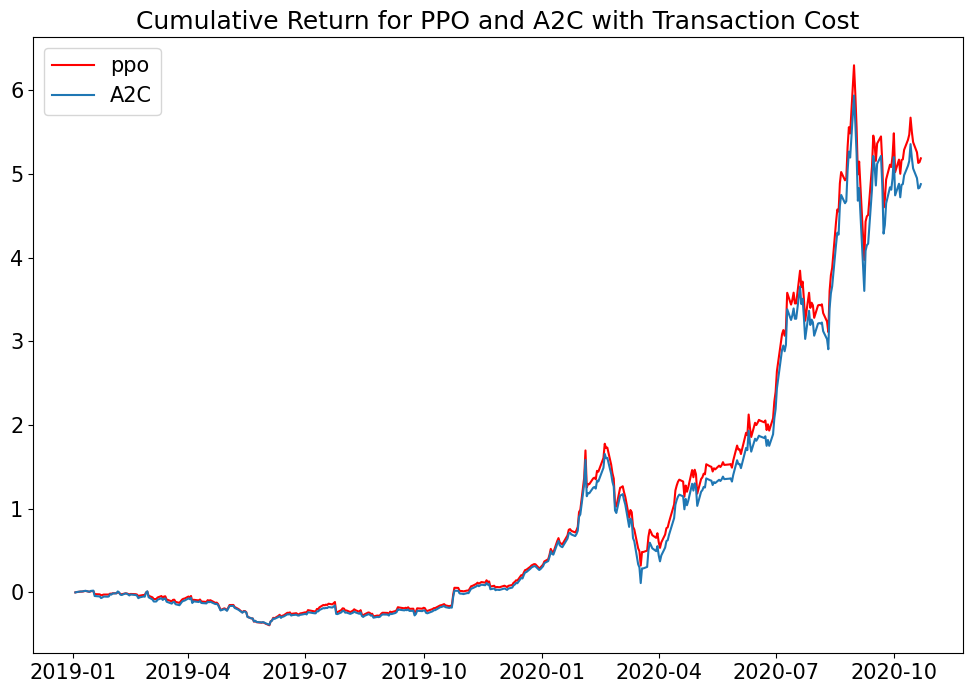

In [42]:

%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.date, cum_return['ppo'], color='red',label = "ppo")
plt.plot(test.date, cum_return['a2c'], label = "A2C")
plt.title("Cumulative Return for PPO and A2C with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

